# New approach to GPs to improve performance

In [85]:
from scipy import stats, special, math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import pymc3 as pm
import arviz as az
import pandas as pd
from theano import shared
import seaborn as sns
import warnings
import theano
import theano.tensor as tt
from IPython.display import HTML, display
import tabulate

az.style.use('arviz-darkgrid')
warnings.filterwarnings('ignore')

In [86]:
prison = pd.read_csv('./data/prisonLF.csv', sep=",")
prison = prison.drop('Unnamed: 0', axis =1)
prison['t'] = prison['t'].astype('datetime64[ns]')

In [87]:
prison_pivot = prison.pivot(index='t',columns=['state', 'gender', 'legal'], values='count')

# Forecast horizon
h = 8
y_train = prison_pivot.iloc[:-8,:]
y = prison_pivot
y_f = y.values

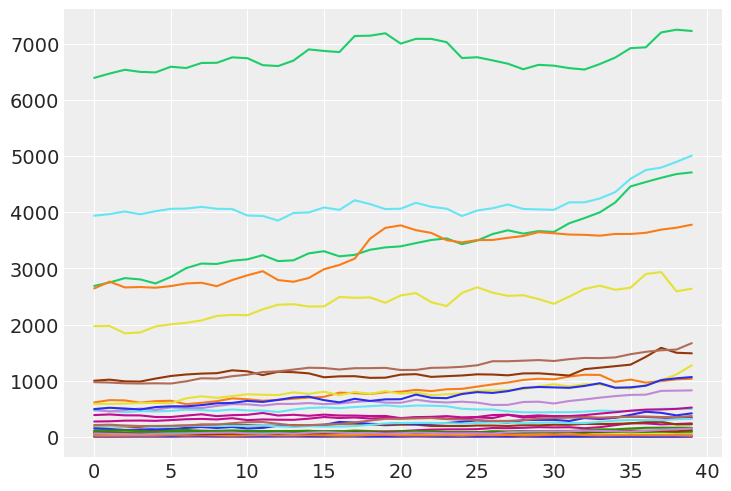

In [88]:
def generate_groups_info(y):
    
    n=y.shape[0]
    s=y.shape[1]
    n_series = y.columns.unique().shape[0]
    
    state_idx = pd.get_dummies(
            [i[0] for i in y]
        ).values.argmax(1)
    state_idx = np.tile(state_idx, (n,1)).flatten('F')
    gender_idx = pd.get_dummies(
            [i[1] for i in y]
        ).values.argmax(1)
    gender_idx = np.tile(gender_idx, (n,1)).flatten('F')

    legal_idx = pd.get_dummies(
            [i[2] for i in y]
        ).values.argmax(1)
    legal_idx = np.tile(legal_idx, (n,1)).flatten('F')

    state = np.unique(state_idx).shape[0]
    gender = np.unique(gender_idx).shape[0]
    legal = np.unique(legal_idx).shape[0]

    n_series_idx = np.tile(np.arange(s), (n,1)).flatten('F')
    n_series_idx_list = np.arange(s)

    state_names = []
    gender_names = []
    legal_names = []
    [state_names.append(i[0]) for i in y.columns]
    [gender_names.append(i[1]) for i in y.columns]
    [legal_names.append(i[2]) for i in y.columns]

    state_names = np.unique(state_names)
    gender_names = np.unique(gender_names)
    legal_names = np.unique(legal_names)

    return (state_idx, 
            gender_idx,
            legal_idx,
            n_series_idx,
            state,
            gender,
            legal,
            n,
            s,
            n_series,
            state_names,
            gender_names,
            legal_names
           )


states_names=[]
gender_names=[]
legal_names=[]

(state_idx, 
 gender_idx, 
 legal_idx,
 n_series_idx, 
 state, 
 gender,
 legal,
 n,
 s,
 n_series,
 state_names,
 gender_names,
 legal_names) = generate_groups_info(y_train)


y_train = y_train.values
y_ = y_train
X = np.arange(y_train.shape[0]).reshape(y_train.shape[0], 1)
plt.plot(X, y_train);

y_ = y_.T.ravel()

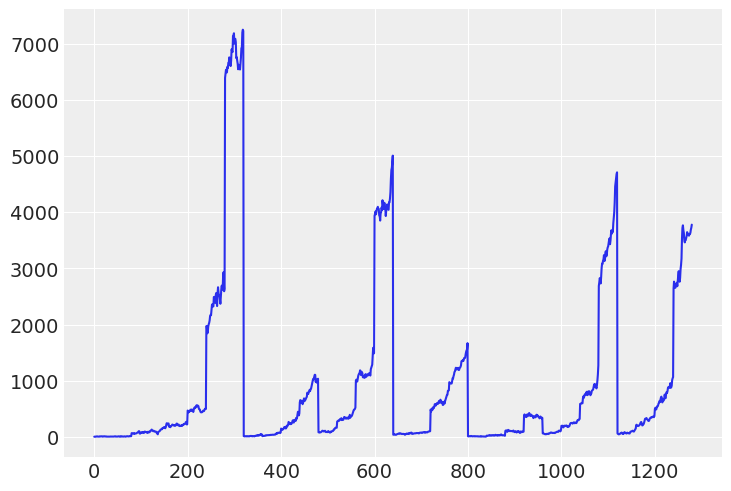

In [89]:
plt.plot(y_);

We will define a more compact covariance matrices to model latent behaviours of each element of each group. We only need them to be UxU where U is the unique number of inputs for the given GP. All the GPs will therefore have a covariance matrix that depend on number of time points and it would be txt, where t is the number of periods observed in the data. In our case it is 48. The Poisson likelihood needs to be computed for the N data points (all time series).

# Group GPs with piecewise linear mean and Poisson likelihood

In [90]:
changepoints = 4
changepoints_t = np.linspace(0, n, changepoints + 2)[1:-1]
changepoints_t

array([ 8., 16., 24., 32.])

In [91]:
def dm_changepoints_theano(X, changepoints_t):
    return (0.5 * (1.0 + tt.sgn(tt.tile(X.reshape((-1,1)), (1,len(changepoints_t))) - changepoints_t)))

class PiecewiseLinearChangepoints(pm.gp.mean.Mean):
    def __init__(self, 
                 k, 
                 m,
                 b,
                 intercept, 
                 changepoints):
        self.k = k
        self.m = m
        self.b = b
        self.a = intercept
        self.changepoints = changepoints

    def __call__(self, X):
        size_r = X.shape[0]

        X = theano.shared(X)
            
        A = dm_changepoints_theano(X[:n,0], self.changepoints)
        
        piecewise = (self.k + tt.dot(A, self.b.reshape((-1,1))))*X + (self.m + tt.dot(A, (-self.changepoints * self.b).reshape((-1,1))))
        
        return (piecewise.reshape((-1,))
                       + tt.tile(self.a, (size_r,)))

In [92]:
class ShiftedGamma(pm.Gamma):
    def __init__(self, alpha, beta, shift, *args, **kwargs):
        transform = pm.distributions.transforms.lowerbound(shift)
        super().__init__(alpha=alpha, beta=beta, *args, **kwargs,
                         transform=transform)
        self.shift = shift
        self.mean += shift
        self.mode += shift
        
    def random(self):
        return super().random() + self.shift
    
    def logp(self, x):
        return super().logp(x - self.shift)

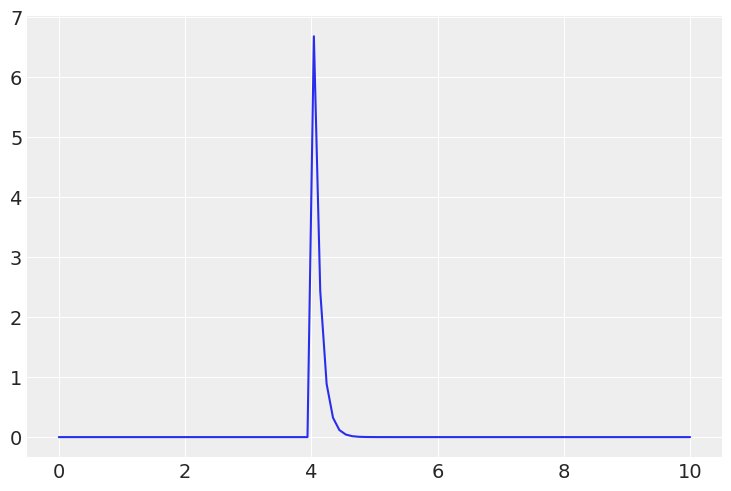

In [93]:
# Option to use instead of laplace for the period RV

alpha = 1
scale = 0.1
loc = 4
x = np.linspace(0, 10, 100)

beta = 1/scale

# likelihood
plt.plot(x, np.exp(ShiftedGamma.dist( 
                      alpha=alpha, 
                      beta=beta, 
                      shift=loc).logp(x).eval()));

In [94]:
gp_dict = {}
f_dict = {}
f_flat = {}
idx_dict = {}

with pm.Model() as m1:
    
    # Hyper-parameter priors
    
    period = pm.Laplace('period', 4, 0.1)
  
    
    l_t_state = pm.Gamma('l_t_state', alpha=5, beta=1, shape = state)
    l_p_state = pm.Gamma('l_p_state', alpha=2, beta=1, shape = state)
    η_trend_state = pm.HalfNormal('η_trend_state', 0.15, shape = state)
    η_per_state = pm.HalfNormal('η_per_state',0.15, shape = state)
    σ_state  = pm.HalfNormal("σ_state",  sigma=0.01, shape = state)
    
    l_t_gender = pm.Gamma('l_t_gender', alpha=5, beta=1, shape = gender)
    l_p_gender = pm.Gamma('l_p_gender', alpha=2, beta=1, shape = gender)
    η_trend_gender = pm.HalfNormal('η_trend_gender', 0.15, shape = gender)
    η_per_gender = pm.HalfNormal('η_per_gender',0.15, shape = gender)
    σ_gender  = pm.HalfNormal("σ_gender",  sigma=0.01, shape = gender)
    
    l_t_legal = pm.Gamma('l_t_legal', alpha=5, beta=1, shape = legal)
    l_p_legal = pm.Gamma('l_p_legal', alpha=2, beta=1, shape = legal)
    η_trend_legal = pm.HalfNormal('η_trend_legal', 0.15, shape = legal)
    η_per_legal = pm.HalfNormal('η_per_legal',0.15, shape = legal)
    σ_legal  = pm.HalfNormal("σ_legal",  sigma=0.01, shape = legal)
    
    
    hy_a0_mu = pm.Normal('hy_a0_mu', mu=0.0, sd=10)
    hy_a_state = pm.Normal('hy_a_state', mu=0.0, sd=5)
    hy_a_gender = pm.Normal('hy_a_gender', mu=0.0, sd=5)
    hy_a_legal = pm.Normal('hy_a_legal', mu=0.0, sd=5)
    
    hy_b_state = pm.Normal('hy_b_state', mu=0.0, sd=0.5)
    hy_b_gender = pm.Normal('hy_b_gender', mu=0.0, sd=0.5)
    hy_b_legal = pm.Normal('hy_b_legal', mu=0.0, sd=0.5)
    
    a0 = pm.Normal('a0', mu=hy_a0_mu, sd=5, shape=n_series)      
    a_state = pm.Normal('a_state', mu=hy_a_state, sd=1, shape=state)
    a_gender = pm.Normal('a_gender', mu=hy_a_gender, sd=1, shape=gender)
    a_legal = pm.Normal('a_legal', mu=hy_a_legal, sd=1, shape=legal)

    b_state = pm.Normal('b_state', mu=hy_b_state, sd=0.1, shape=(len(changepoints_t),state))
    b_gender = pm.Normal('b_gender', mu=hy_b_gender, sd=0.1, shape=(len(changepoints_t),gender))
    b_legal = pm.Normal('b_legal', mu=hy_b_legal, sd=0.1, shape=(len(changepoints_t),legal))

    
    k_state = pm.Normal("k_state", mu=0, sigma=0.1, shape=state)
    m_state = pm.Normal("m_state", mu=0, sigma=0.1, shape=state)
    k_gender = pm.Normal("k_gender", mu=0, sigma=0.1, shape=gender)
    m_gender = pm.Normal("m_gender", mu=0, sigma=0.1, shape=gender)
    k_legal = pm.Normal("k_legal", mu=0, sigma=0.1, shape=legal)
    m_legal = pm.Normal("m_legal", mu=0, sigma=0.1, shape=legal)
       
    for idx, name in enumerate(state_names):
        
        # index varible that indicates where a specific GP is active
        # for instance, GP_fem is only active in fem time series
        idx_dict[name] = np.where(state_idx==idx,1,0)
        
        # mean function for the GP with specific parameters per group
        mu_func = PiecewiseLinearChangepoints(intercept = a_state[idx],
                                              b = b_state[:,idx],
                                              changepoints = changepoints_t,
                                              k = k_state[idx],
                                              m = m_state[idx])
        
        # cov function for the GP with specific parameters per group
        cov = (η_trend_state[idx]**2 * pm.gp.cov.Matern32(input_dim=1, ls=l_t_state[idx])
                + η_per_state[idx]**2 * pm.gp.cov.Periodic(1, period=period, ls=l_p_state[idx]) 
                + pm.gp.cov.WhiteNoise(σ_state[idx]))
        
        gp_dict[name] = pm.gp.Latent(mean_func=mu_func, cov_func=cov)
        f_dict[name] = gp_dict[name].prior('f_%s' % name, X=X, reparameterize=True)
        f_flat[name] = tt.tile(f_dict[name], (s,)) * idx_dict[name]
        
    for idx, name in enumerate(gender_names):
        
        idx_dict[name] = np.where(gender_idx==idx,1,0)
        
        mu_func = PiecewiseLinearChangepoints(intercept = a_gender[idx],
                                              b = b_gender[:,idx],
                                              changepoints = changepoints_t,
                                              k = k_gender[idx],
                                              m = m_gender[idx])
        
        cov = (η_trend_gender[idx]**2 * pm.gp.cov.Matern32(input_dim=1, ls=l_t_gender[idx])
                + η_per_gender[idx]**2 * pm.gp.cov.Periodic(1, period=period, ls=l_p_gender[idx]) 
                + pm.gp.cov.WhiteNoise(σ_gender[idx]))
        
        gp_dict[name] = pm.gp.Latent(mean_func=mu_func, cov_func=cov)
        f_dict[name] = gp_dict[name].prior('f_%s' % name, X=X, reparameterize=True)
        f_flat[name] = tt.tile(f_dict[name], (s,)) * idx_dict[name]
        
    for idx, name in enumerate(legal_names):
        
        idx_dict[name] = np.where(legal_idx==idx,1,0)
        
        mu_func = PiecewiseLinearChangepoints(intercept = a_legal[idx],
                                              b = b_legal[:,idx],
                                              changepoints = changepoints_t,
                                              k = k_legal[idx],
                                              m = m_legal[idx])
        
        cov = (η_trend_legal[idx]**2 * pm.gp.cov.Matern32(input_dim=1, ls=l_t_legal[idx])
                + η_per_legal[idx]**2 * pm.gp.cov.Periodic(1, period=period, ls=l_p_legal[idx]) 
                + pm.gp.cov.WhiteNoise(σ_legal[idx]))
        
        gp_dict[name] = pm.gp.Latent(mean_func=mu_func, cov_func=cov)
        f_dict[name] = gp_dict[name].prior('f_ %s' % name, X=X, reparameterize=True)
        f_flat[name] = tt.tile(f_dict[name], (s,)) * idx_dict[name]
        
    
    # Sum of all the GPs designed per group
    f = sum(f_flat.values())
        
    
    y_pred = pm.Poisson('y_pred', mu=tt.exp(f + a0[n_series_idx]), observed=y_)

In [95]:
with m1:
    mp = pm.find_MAP()

In [96]:
mp_list = [{key: mp.get(key) for key in [i for i in mp if not any(j in i for j in ['log', 'f_rotated_', 'rotated'])]}]

In [97]:
mp_list

[{'period': array(4.00039192),
  'hy_a0_mu': array(0.00229313),
  'hy_a_state': array(0.05497308),
  'hy_a_gender': array(0.05679698),
  'hy_a_legal': array(0.05679698),
  'hy_b_state': array(0.00014817),
  'hy_b_gender': array(0.00037454),
  'hy_b_legal': array(0.00037454),
  'a0': array([-0.00578918, -0.73095677,  0.04107387, -0.32086992,  0.43894328,
          0.32216613,  0.4389029 ,  0.53128626, -0.15081218, -0.30975109,
          0.02538962,  0.28412572,  0.17568085,  0.4623913 ,  0.17264345,
          0.50873943,  0.31490062, -0.28787357,  0.34040731,  0.09553   ,
         -0.21478395, -0.04960531, -0.24935646,  0.1336571 ,  0.05974809,
          0.2701023 ,  0.04769056,  0.57353832,  0.11068236,  0.45260553,
         -0.06316021,  0.4866593 ]),
  'a_state': array([-1.00164254,  1.70665566, -0.14835532,  1.30076508,  0.45695977,
         -0.37411003,  0.93790703,  0.97303389]),
  'a_gender': array([0.84593364, 3.00345579]),
  'a_legal': array([1.4616899 , 2.38769953]),
  'b_stat

In [98]:
with m1:
    pred_samples = pm.sample_posterior_predictive([mp], 
                                                  vars=[y_pred], 
                                                  samples=500)

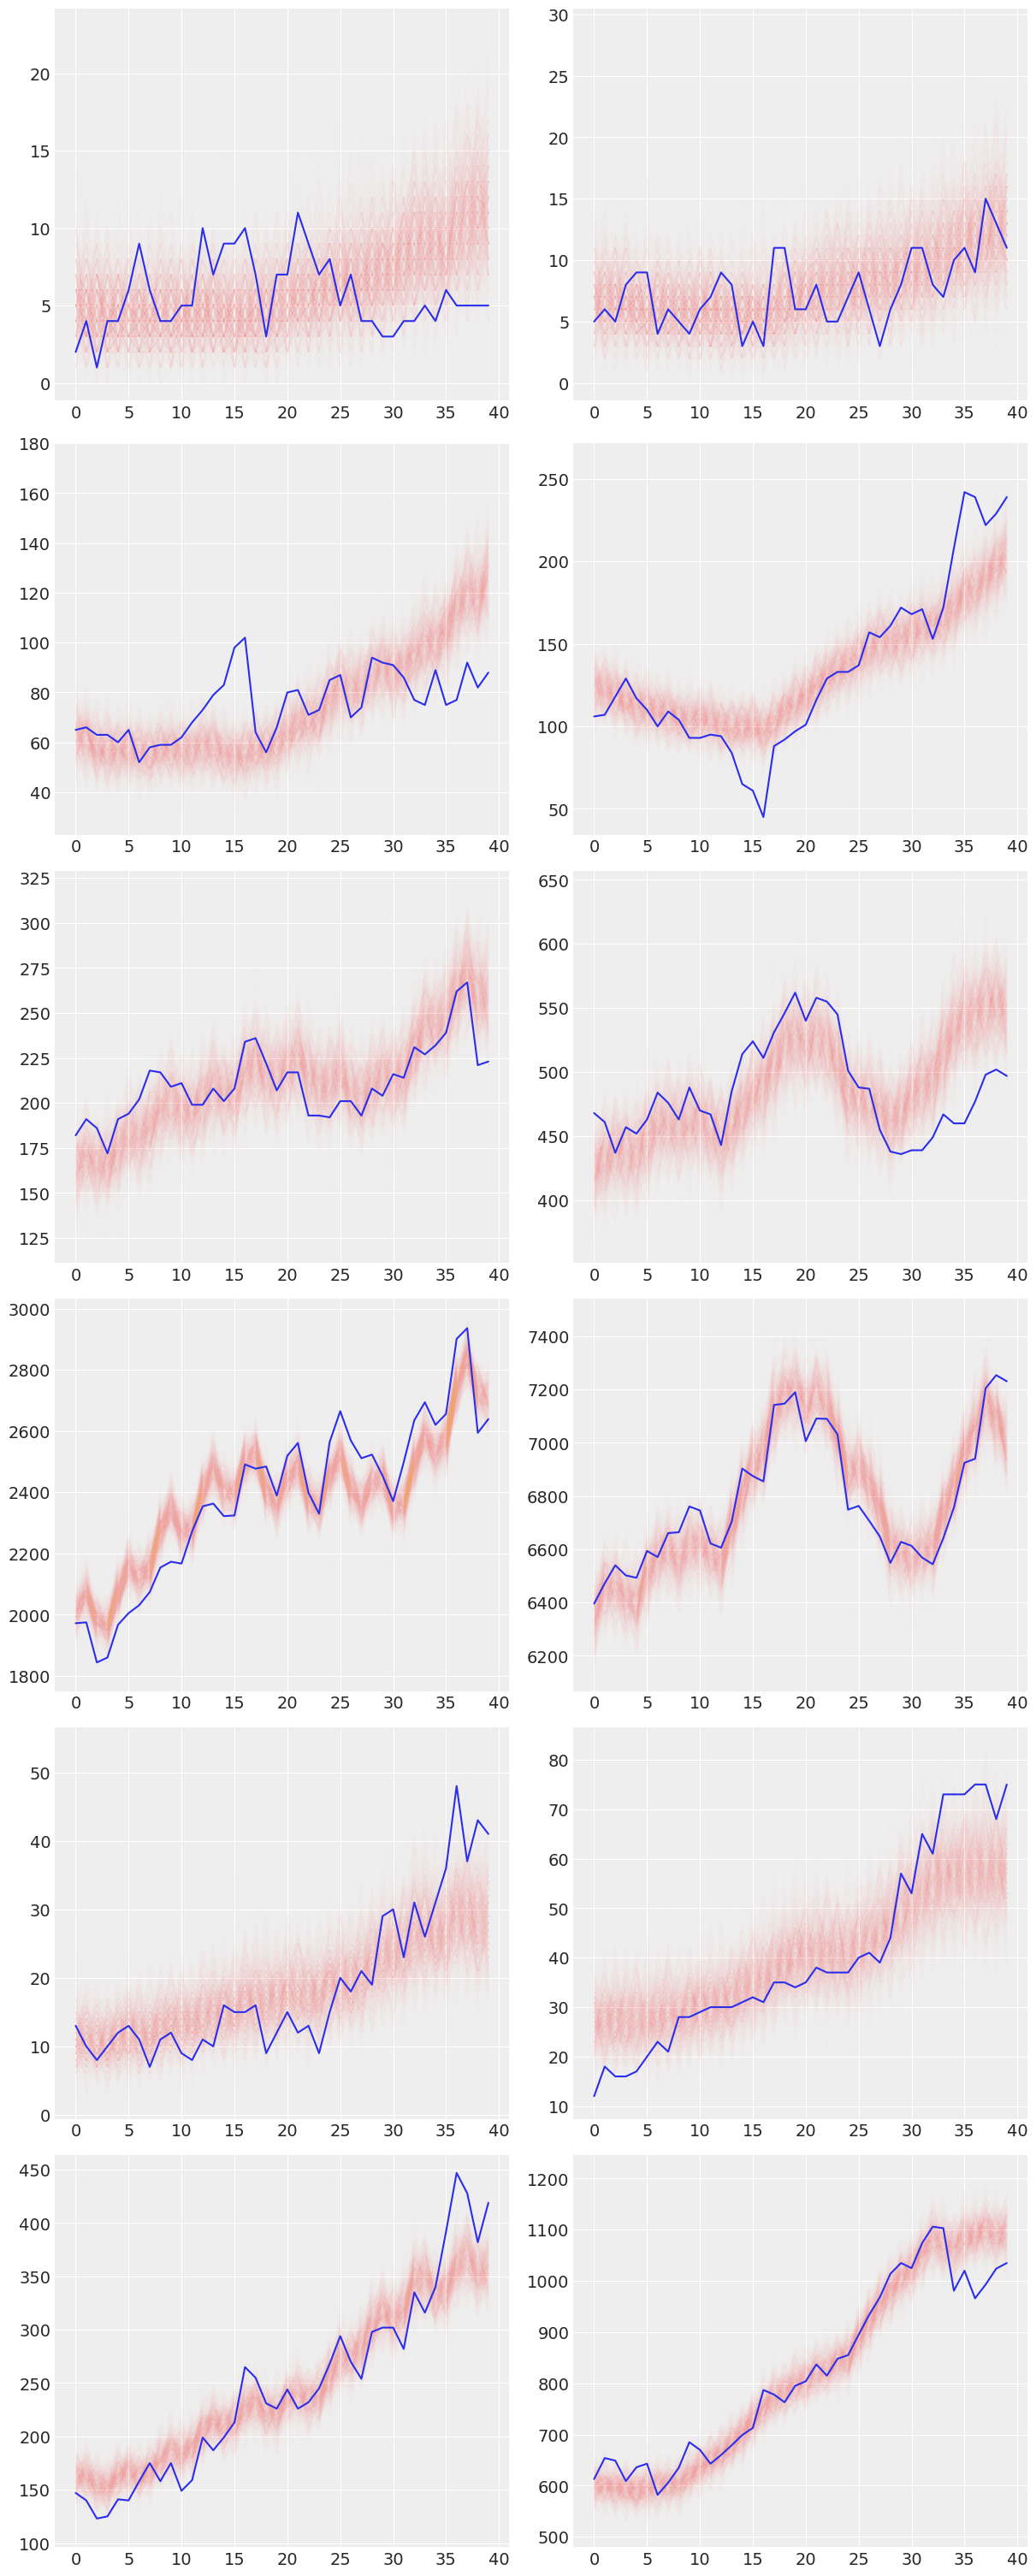

In [99]:
fig, ax = plt.subplots(6, 2, figsize=(12,30))
ax = np.ravel(ax)
for i in range(12):
    ax[i].plot(np.arange(n), pred_samples['y_pred'].T[i*n:i*n+n,:], alpha=0.003, color='orange')
    ax[i].plot(y_train[:,i]);

In [100]:
n_new = n+h
X_new = np.arange(n_new).reshape(-1,1)

In [101]:
(state_idx, 
 gender_idx, 
 legal_idx,
 n_series_idx, 
 state, 
 gender,
 legal,
 n,
 s,
 n_series,
 state_names,
 gender_names,
 legal_names) = generate_groups_info(y)

In [102]:
f_new = {}
f_flat_new = {}
idx_dict_new = {}

with m1:
    
    for idx, name in enumerate(state_names):
        idx_dict_new[name] = np.where(state_idx==idx,1,0)
        f_new[name] = gp_dict[name].conditional('f_new%s'%name, Xnew = X_new)
        f_flat_new[name] = tt.tile(f_new[name], (s,)) * idx_dict_new[name]

    for idx, name in enumerate(gender_names):
        idx_dict_new[name] = np.where(gender_idx==idx,1,0)
        f_new[name] = gp_dict[name].conditional('f_new%s'%name, Xnew = X_new)
        f_flat_new[name] = tt.tile(f_new[name], (s,)) * idx_dict_new[name]
        
    for idx, name in enumerate(legal_names):
        idx_dict_new[name] = np.where(legal_idx==idx,1,0)
        f_new[name] = gp_dict[name].conditional('f_new%s'%name, Xnew = X_new)
        f_flat_new[name] = tt.tile(f_new[name], (s,)) * idx_dict_new[name]

In [103]:
with m1:

    f_ = sum(f_flat_new.values())
    
    y_pred_new = pm.Poisson("y_pred_new", 
                            mu=pm.math.exp(f_ + a0[n_series_idx]), 
                            shape=n_new * s)

In [104]:
with m1:
    pred_samples = pm.sample_posterior_predictive([mp], 
                                                  vars=[y_pred_new], 
                                                  samples=200)

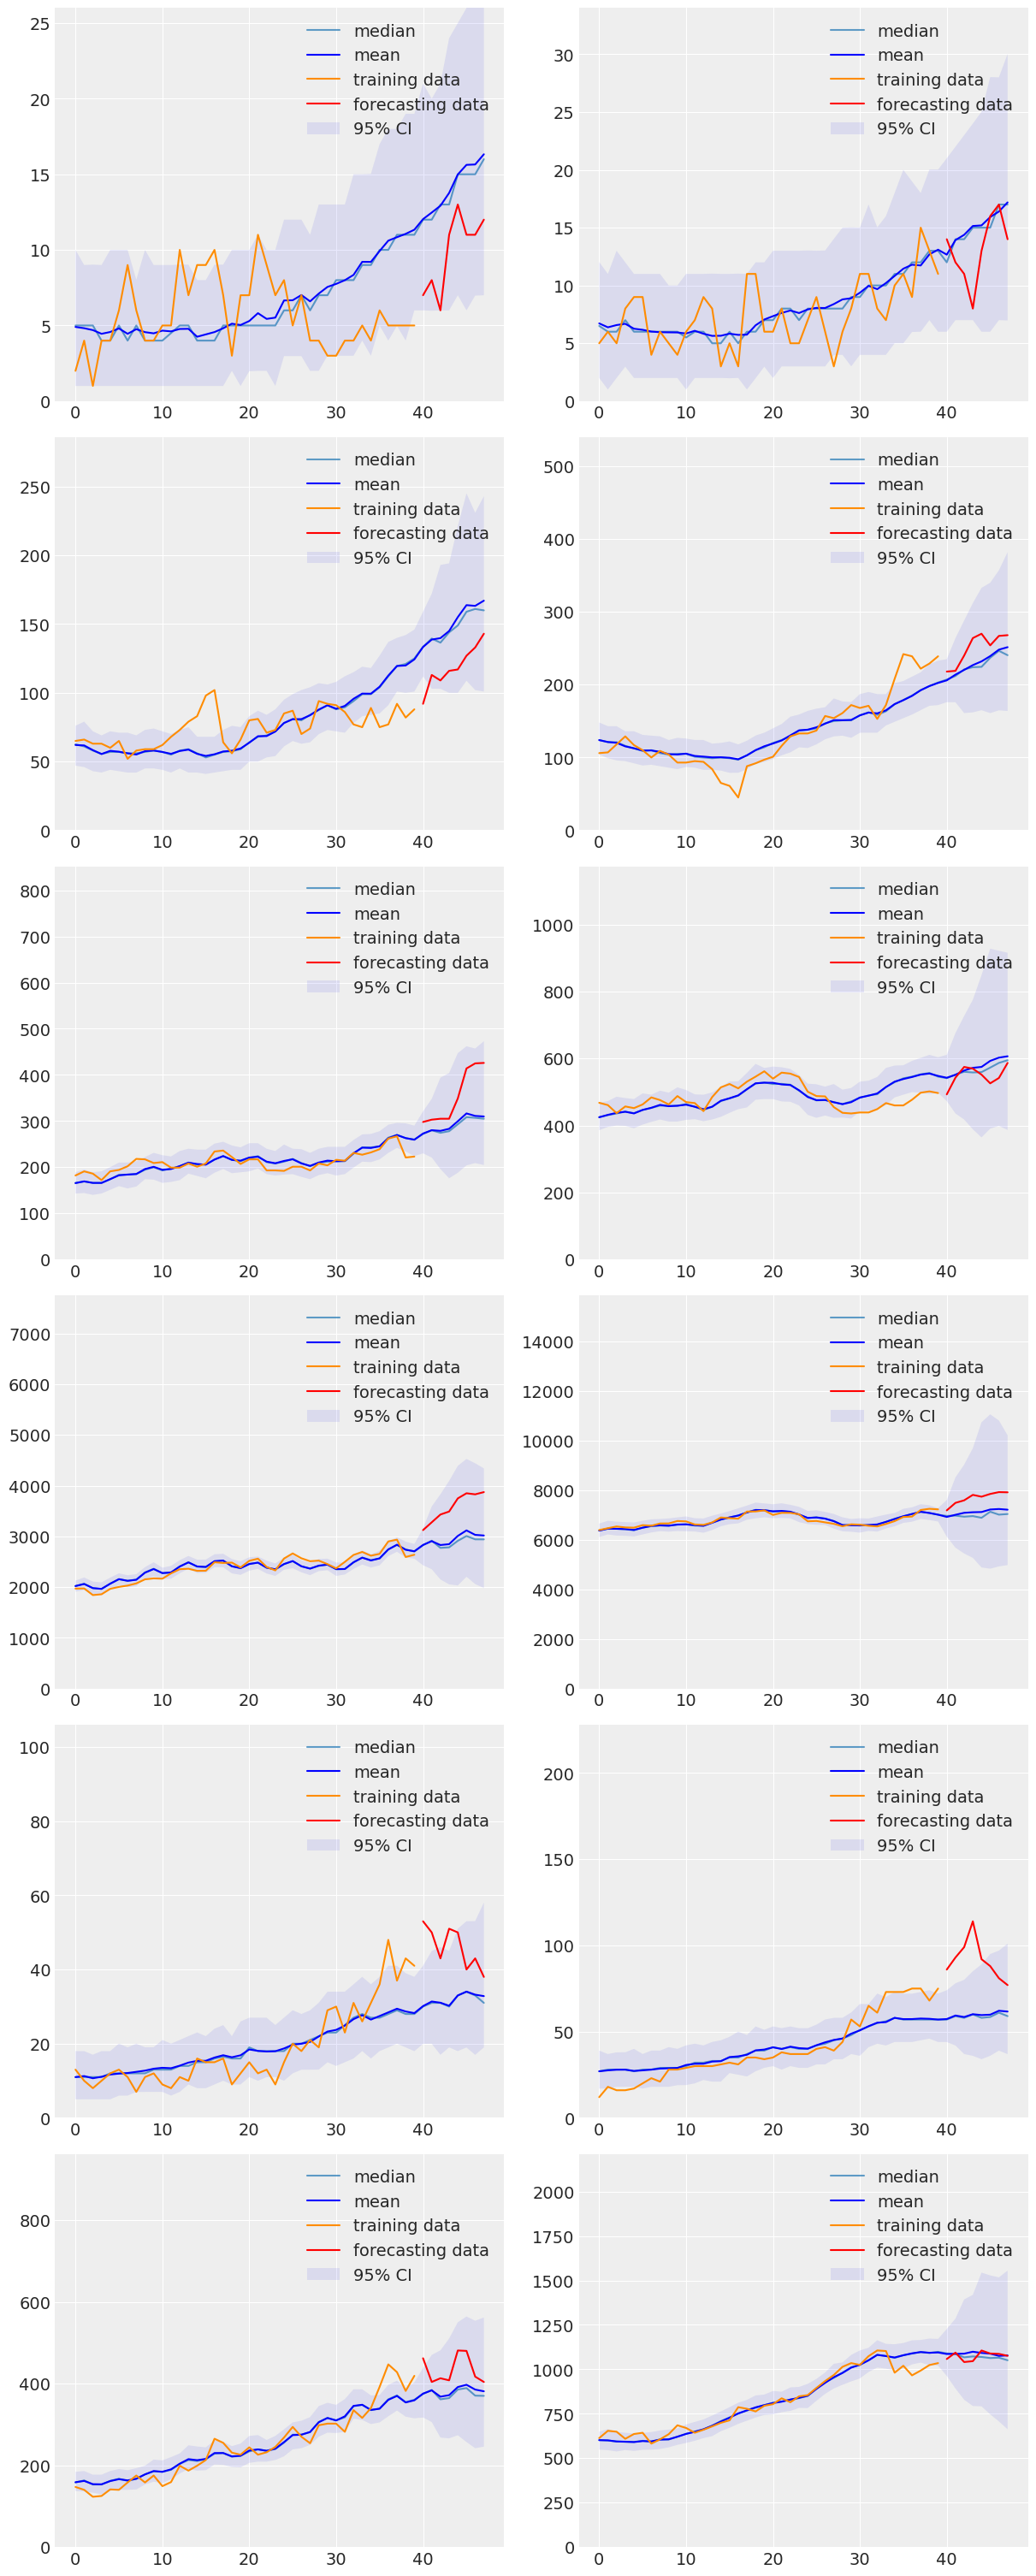

In [105]:
fig, ax = plt.subplots(6, 2, figsize=(12,30))
ax = np.ravel(ax)

for i in range(12):
    #ax[i].plot(np.arange(n_new), pred_samples['y_pred_new'].T[i*n:i*n+n,:], alpha=0.003, color='blue')
    ax[i].fill_between(np.arange(n_new), 
                       np.percentile(pred_samples['y_pred_new'].T[i*n:i*n+n,:], axis=1, q=2.5),
                      np.percentile(pred_samples['y_pred_new'].T[i*n:i*n+n,:], axis=1, q=97.5),
                      label='95% CI', alpha=0.1)
    ax[i].plot(np.arange(n_new), np.median(pred_samples['y_pred_new'].T[i*n:i*n+n,:], axis=1), color='tab:blue', alpha=0.7, label='median')
    ax[i].plot(np.arange(n_new), np.mean(pred_samples['y_pred_new'].T[i*n:i*n+n,:], axis=1), color='b', label='mean')
    ax[i].set_ylim(0,max(y_f[:,i])*2)
    ax[i].plot(y_f[:-8,i], color='darkorange', label='training data')
    ax[i].plot(np.arange(n_new -8, n_new), y_f[n_new-8:,i], color='r', label='forecasting data')
    ax[i].legend();

# Functions to calculate results

https://arxiv.org/pdf/2006.02043.pdf

$$MASE = \frac{n-s}{h}\frac{\sum^{n+h}_{t=n+1}|y_t-f_t|}{\sum^n_{t=s+1}|y_t-y_{t-s}|}$$

where $y_t$ and $f_t$ are the observation and the forecast for period $t$,$n$ is the sample size (observations used for training the forecasting model), $s$ is the length of the seasonal period, and $h$ is the forecasting horizon. Lower values indicate better forecasts.

Note that measure is scale-independent, meaning that averaging across series is possible.

In [106]:
def mase(n,s,h,y,f, series=0):
    return ((n-s)/h
            * (np.sum(np.abs(y[n:n+h,series] - f[:,series]))
               / np.sum(np.abs(y[s:n, series] - y[:n-s, series]))))

In [109]:
def calculate_metrics(fn,
                      pred_samples, 
                      y_f,
                      state_names,
                      gender_names,
                      legal_names):
    
    # Bottom
    mase_sum_bottom = []
    for i in range(s):
        mase_sum_bottom.append(mase(n=40, 
                             s=4, 
                             h=8, 
                             y=y_f, 
                             f=fn(pred_samples['y_pred_new'], axis=0).reshape(s, n).T[n-8:n,:], 
                             series=i))

    mase_bottom = np.round(np.sum(mase_sum_bottom)/s,3)

    # total
    mase_total = np.round(mase(n=40, 
                     s=4, 
                     h=8, 
                     y=np.sum(y_f, axis=1).reshape(-1,1), 
                     f=np.sum(fn(pred_samples['y_pred_new'], axis=0).reshape(s, n).T[n-8:n,:], axis=1).reshape(-1,1)),3)

    # State
    idx_state_new = {key: idx_dict_new.get(key) for key in 
      [i for i in idx_dict_new if 
       any(j in i for j in state_names)]}

    y_st = np.zeros((n, state_names.shape[0]))
    f_st = np.zeros((8, state_names.shape[0]))

    for i, st in enumerate(state_names):
        y_st[:,i] = np.sum(idx_state_new[st].reshape(s, n).T*y_f, axis=1)
        f_st[:,i] = np.sum(idx_state_new[st].reshape(s, n).T*np.mean(pred_samples['y_pred_new'], axis=0).reshape(s, n).T, axis=1)[n-8:n]

    mase_state = []
    for i in range(state):
        mase_state.append(mase(n=40, 
                         s=4, 
                         h=8, 
                         y=y_st, 
                         f=f_st,
                         series=i))

    mase_state = np.round(np.sum(mase_state)/state,3)

    # Gender
    idx_gender_new = {key: idx_dict_new.get(key) for key in 
      [i for i in idx_dict_new if 
       any(j in i for j in gender_names)]}

    y_ge = np.zeros((n, gender_names.shape[0]))
    f_ge = np.zeros((8, gender_names.shape[0]))

    for i, ge in enumerate(gender_names):
        y_ge[:,i] = np.sum(idx_gender_new[ge].reshape(s, n).T*y_f, axis=1)
        f_ge[:,i] = np.sum(idx_gender_new[ge].reshape(s, n).T*fn(pred_samples['y_pred_new'], axis=0).reshape(s, n).T, axis=1)[n-8:n]

    mase_gender = []
    for i in range(gender):
        mase_gender.append(mase(n=40, 
                         s=4, 
                         h=8, 
                         y=y_ge, 
                         f=f_ge,
                         series=i))

    mase_gender = np.round(np.sum(mase_gender)/gender, 3)

    # Legal
    idx_legal_new = {key: idx_dict_new.get(key) for key in 
      [i for i in idx_dict_new if 
       any(j in i for j in legal_names)]}

    y_le = np.zeros((n, legal_names.shape[0]))
    f_le = np.zeros((8, legal_names.shape[0]))

    for i, le in enumerate(legal_names):
        y_le[:,i] = np.sum(idx_legal_new[le].reshape(s, n).T*y_f, axis=1)
        f_le[:,i] = np.sum(idx_legal_new[le].reshape(s, n).T*fn(pred_samples['y_pred_new'], axis=0).reshape(s, n).T, axis=1)[n-8:n]

    mase_legal = []
    for i in range(legal):
        mase_legal.append(mase(n=40, 
                         s=4, 
                         h=8, 
                         y=y_le, 
                         f=f_le,
                         series=i))

    mase_legal = np.round(np.sum(mase_legal)/legal,3)

    # All
    y_all = np.concatenate((y_f, y_st, y_ge, y_le), axis=1)
    f_all = np.concatenate((fn(pred_samples['y_pred_new'], axis=0).reshape(s, n).T[n-8:n,:],
                   f_st,
                   f_ge,
                   f_le), axis=1)

    mase_all = []
    for i in range(y_all.shape[1]):
        mase_all.append(mase(n=40, 
                         s=4, 
                         h=8, 
                         y=y_all, 
                         f=f_all,
                         series=i))

    mase_all = np.round(np.sum(mase_all)/y_all.shape[1], 3)
    
    return mase_bottom, mase_total, mase_state, mase_gender, mase_legal, mase_all

In [110]:
(mase_bottom_mean_m1, 
 mase_total_mean_m1, 
 mase_state_mean_m1, 
 mase_gender_mean_m1,
 mase_legal_mean_m1,
 mase_all_mean_m1) = calculate_metrics(np.mean,
                      pred_samples, 
                      y_f, 
                      state_names,
                      gender_names,
                      legal_names)

# Group GPs with linear mean and Poisson likelihood

In [111]:
y_train = prison_pivot.iloc[:-8,:]

(state_idx, 
 gender_idx, 
 legal_idx,
 n_series_idx, 
 state, 
 gender,
 legal,
 n,
 s,
 n_series,
 state_names,
 gender_names,
 legal_names) = generate_groups_info(y_train)

In [112]:
gp_dict = {}
f_dict = {}
f_flat = {}
idx_dict = {}

with pm.Model() as m2:
    
    # Hyper-parameter priors
    
    period = pm.Laplace('period', 4, 0.1)
  
    
    l_t_state = pm.Gamma('l_t_state', alpha=5, beta=1, shape = state)
    l_p_state = pm.Gamma('l_p_state', alpha=2, beta=1, shape = state)
    η_trend_state = pm.HalfNormal('η_trend_state', 0.15, shape = state)
    η_per_state = pm.HalfNormal('η_per_state',0.15, shape = state)
    σ_state  = pm.HalfNormal("σ_state",  sigma=0.01, shape = state)
    
    l_t_gender = pm.Gamma('l_t_gender', alpha=5, beta=1, shape = gender)
    l_p_gender = pm.Gamma('l_p_gender', alpha=2, beta=1, shape = gender)
    η_trend_gender = pm.HalfNormal('η_trend_gender', 0.15, shape = gender)
    η_per_gender = pm.HalfNormal('η_per_gender',0.15, shape = gender)
    σ_gender  = pm.HalfNormal("σ_gender",  sigma=0.01, shape = gender)
    
    l_t_legal = pm.Gamma('l_t_legal', alpha=5, beta=1, shape = legal)
    l_p_legal = pm.Gamma('l_p_legal', alpha=2, beta=1, shape = legal)
    η_trend_legal = pm.HalfNormal('η_trend_legal', 0.15, shape = legal)
    η_per_legal = pm.HalfNormal('η_per_legal',0.15, shape = legal)
    σ_legal  = pm.HalfNormal("σ_legal",  sigma=0.01, shape = legal)
    
    
    hy_a0_mu = pm.Normal('hy_a0_mu', mu=0.0, sd=10)
    hy_a_state = pm.Normal('hy_a_state', mu=0.0, sd=5)
    hy_a_gender = pm.Normal('hy_a_gender', mu=0.0, sd=5)
    hy_a_legal = pm.Normal('hy_a_legal', mu=0.0, sd=5)
    
    hy_b_state = pm.Normal('hy_b_state', mu=0.0, sd=0.5)
    hy_b_gender = pm.Normal('hy_b_gender', mu=0.0, sd=0.5)
    hy_b_legal = pm.Normal('hy_b_legal', mu=0.0, sd=0.5)
    
    a0 = pm.Normal('a0', mu=hy_a0_mu, sd=5, shape=n_series)      
    a_state = pm.Normal('a_state', mu=hy_a_state, sd=1, shape=state)
    a_gender = pm.Normal('a_gender', mu=hy_a_gender, sd=1, shape=gender)
    a_legal = pm.Normal('a_legal', mu=hy_a_legal, sd=1, shape=legal)

    b_state = pm.Normal('b_state', mu=hy_b_state, sd=0.1, shape=state)
    b_gender = pm.Normal('b_gender', mu=hy_b_gender, sd=0.1, shape=gender)
    b_legal = pm.Normal('b_legal', mu=hy_b_legal, sd=0.1, shape=legal)
       
    for idx, name in enumerate(state_names):
        
        # index varible that indicates where a specific GP is active
        # for instance, GP_fem is only active in fem time series
        idx_dict[name] = np.where(state_idx==idx,1,0)
        
        # mean function for the GP with specific parameters per group       
        mu_func = pm.gp.mean.Linear(intercept = a_state[idx],
                                   coeffs = b_state[idx])
        
        # cov function for the GP with specific parameters per group
        cov = (η_trend_state[idx]**2 * pm.gp.cov.Matern32(input_dim=1, ls=l_t_state[idx])
                + η_per_state[idx]**2 * pm.gp.cov.Periodic(1, period=period, ls=l_p_state[idx]) 
                + pm.gp.cov.WhiteNoise(σ_state[idx]))
        
        gp_dict[name] = pm.gp.Latent(mean_func=mu_func, cov_func=cov)
        f_dict[name] = gp_dict[name].prior('f_%s' % name, X=X, reparameterize=True)
        f_flat[name] = tt.tile(f_dict[name], (s,)) * idx_dict[name]
        
    for idx, name in enumerate(gender_names):
        
        idx_dict[name] = np.where(gender_idx==idx,1,0)
        
        mu_func = pm.gp.mean.Linear(intercept = a_gender[idx],
                                   coeffs = b_gender[idx])
        
        cov = (η_trend_gender[idx]**2 * pm.gp.cov.Matern32(input_dim=1, ls=l_t_gender[idx])
                + η_per_gender[idx]**2 * pm.gp.cov.Periodic(1, period=period, ls=l_p_gender[idx]) 
                + pm.gp.cov.WhiteNoise(σ_gender[idx]))
        
        gp_dict[name] = pm.gp.Latent(mean_func=mu_func, cov_func=cov)
        f_dict[name] = gp_dict[name].prior('f_%s' % name, X=X, reparameterize=True)
        f_flat[name] = tt.tile(f_dict[name], (s,)) * idx_dict[name]
        
    for idx, name in enumerate(legal_names):
        
        idx_dict[name] = np.where(legal_idx==idx,1,0)
        
        mu_func = pm.gp.mean.Linear(intercept = a_legal[idx],
                                   coeffs = b_legal[idx])
        
        cov = (η_trend_legal[idx]**2 * pm.gp.cov.Matern32(input_dim=1, ls=l_t_legal[idx])
                + η_per_legal[idx]**2 * pm.gp.cov.Periodic(1, period=period, ls=l_p_legal[idx]) 
                + pm.gp.cov.WhiteNoise(σ_legal[idx]))
        
        gp_dict[name] = pm.gp.Latent(mean_func=mu_func, cov_func=cov)
        f_dict[name] = gp_dict[name].prior('f_ %s' % name, X=X, reparameterize=True)
        f_flat[name] = tt.tile(f_dict[name], (s,)) * idx_dict[name]
        
    
    # Sum of all the GPs designed per group
    f = sum(f_flat.values())
        
    
    y_pred = pm.Poisson('y_pred', mu=tt.exp(f + a0[n_series_idx]), observed=y_)

In [113]:
with m2:
    mp = pm.find_MAP()

In [114]:
mp_list = [{key: mp.get(key) for key in [i for i in mp if not any(j in i for j in ['log', 'f_rotated_', 'rotated'])]}]

In [115]:
mp_list

[{'period': array(3.99802173),
  'hy_a0_mu': array(0.00787264),
  'hy_a_state': array(0.17645533),
  'hy_a_gender': array(0.19210155),
  'hy_a_legal': array(0.19210155),
  'hy_b_state': array(0.00209676),
  'hy_b_gender': array(0.0058321),
  'hy_b_legal': array(0.0058321),
  'a0': array([-0.1458341 , -0.80115262,  0.01869692, -0.33944086,  0.49831096,
          0.38263671,  0.51006197,  0.6084493 , -0.16123802, -0.31508233,
          0.02402323,  0.29065566,  0.22032214,  0.50433355,  0.21932099,
          0.56072945,  0.332832  , -0.26968745,  0.3735885 ,  0.13129207,
         -0.22973293, -0.04527541, -0.23412841,  0.14840326,  0.09328737,
          0.30591144,  0.08753975,  0.61861408,  0.14566467,  0.48803622,
         -0.01991375,  0.53404344]),
  'a_state': array([-1.21002832,  1.91775709, -0.15194265,  1.44381347,  0.54666116,
         -0.34317883,  1.0614216 ,  1.10207605]),
  'a_gender': array([0.96435095, 3.38657772]),
  'a_legal': array([1.66323382, 2.68769485]),
  'b_state'

In [116]:
with m2:
    pred_samples = pm.sample_posterior_predictive([mp], 
                                                  vars=[y_pred], 
                                                  samples=500)

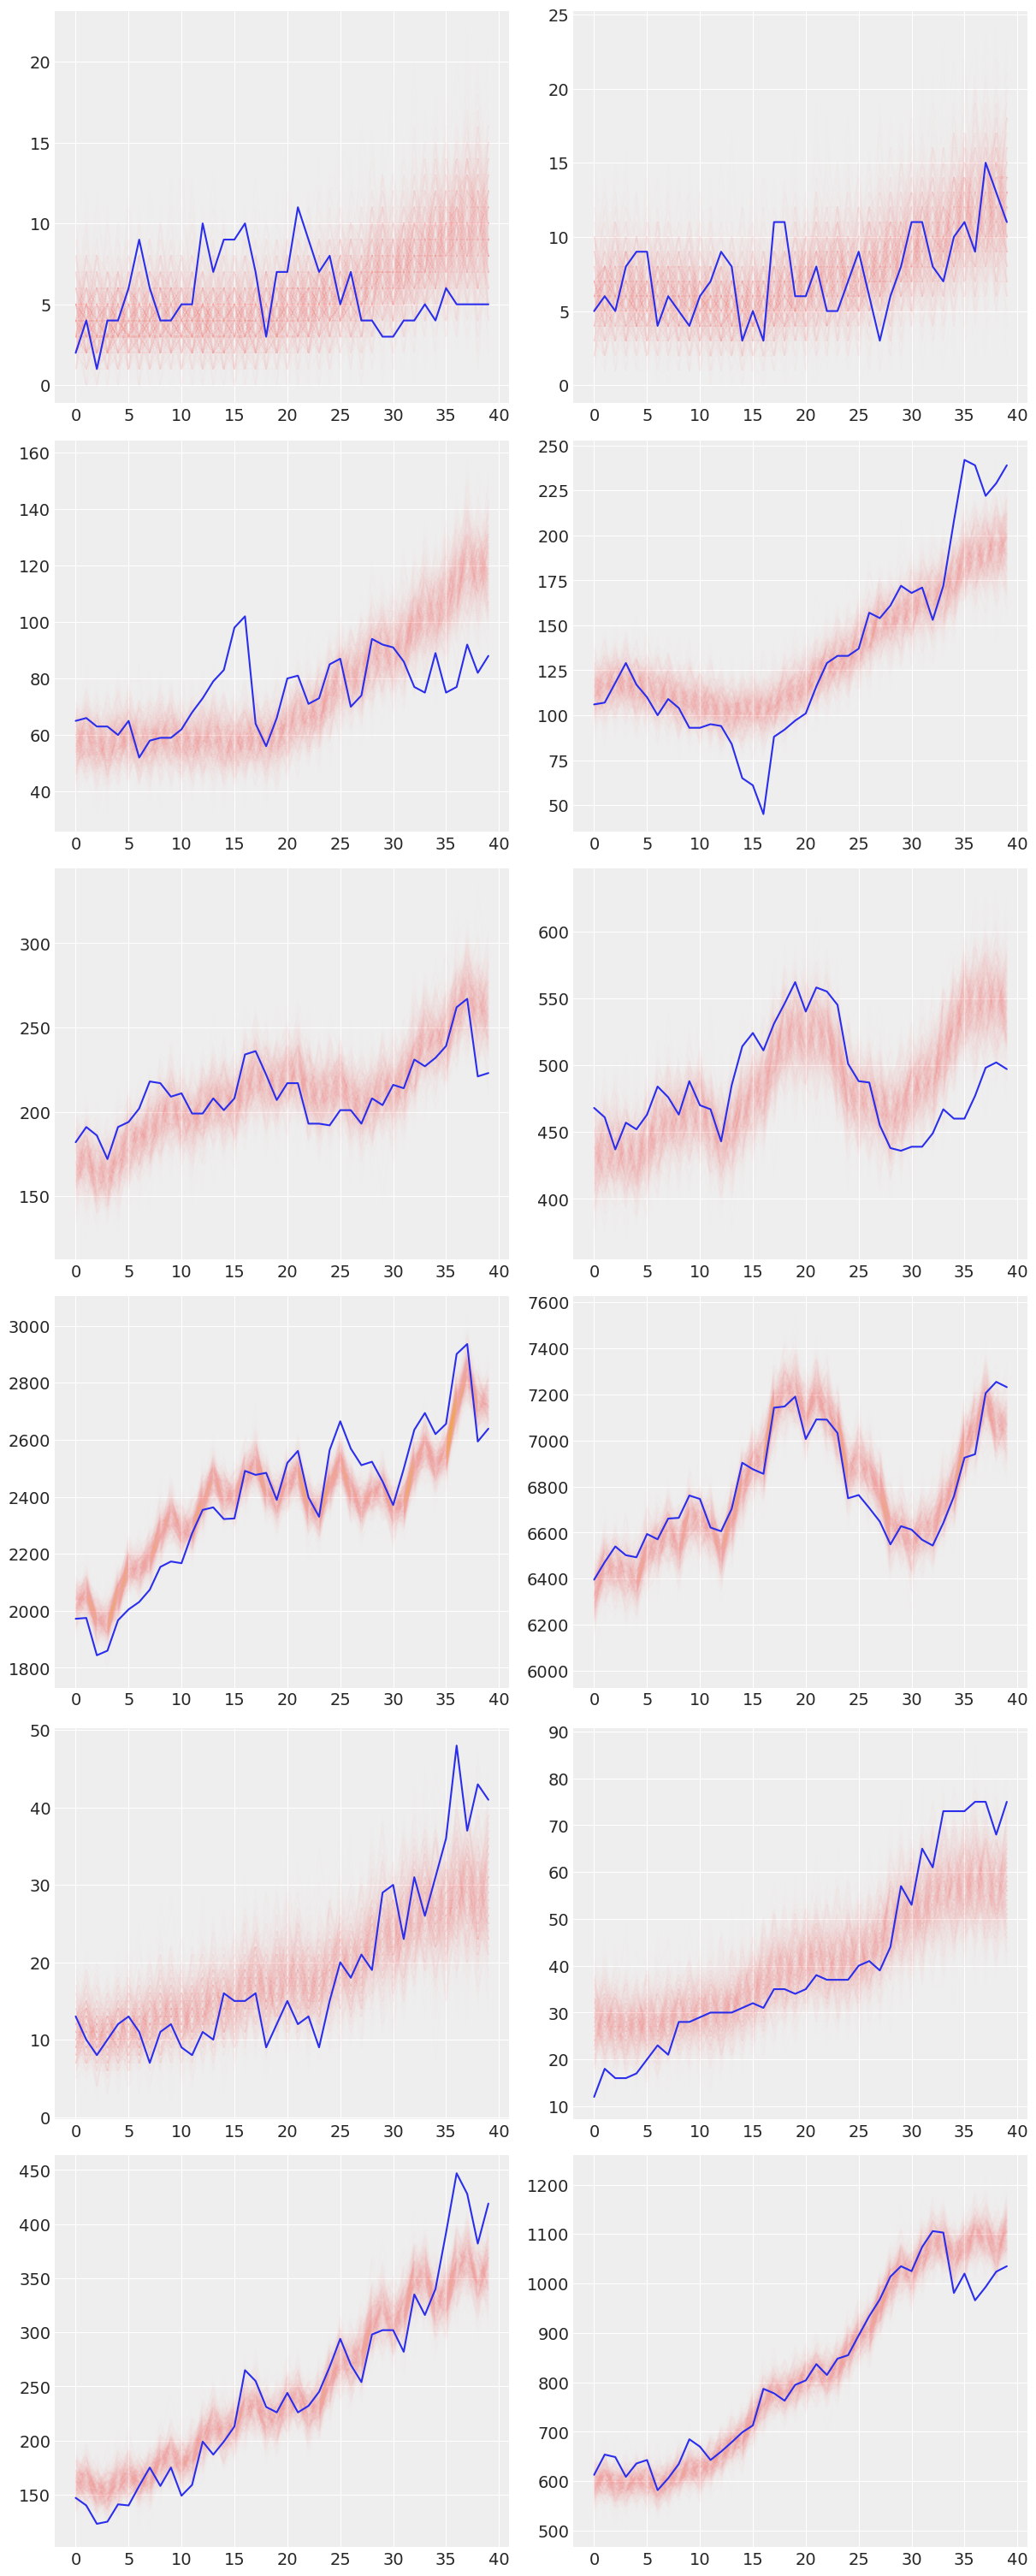

In [117]:
y_train = y_train.values
fig, ax = plt.subplots(6, 2, figsize=(12,30))
ax = np.ravel(ax)
for i in range(12):
    ax[i].plot(np.arange(n), pred_samples['y_pred'].T[i*n:i*n+n,:], alpha=0.003, color='orange')
    ax[i].plot(y_train[:,i]);

In [118]:
n_new = n+h
X_new = np.arange(n_new).reshape(-1,1)

In [119]:
(state_idx, 
 gender_idx, 
 legal_idx,
 n_series_idx, 
 state, 
 gender,
 legal,
 n,
 s,
 n_series,
 state_names,
 gender_names,
 legal_names) = generate_groups_info(y)

In [120]:
f_new = {}
f_flat_new = {}
idx_dict_new = {}

with m2:
    
    for idx, name in enumerate(state_names):
        idx_dict_new[name] = np.where(state_idx==idx,1,0)
        f_new[name] = gp_dict[name].conditional('f_new%s'%name, Xnew = X_new)
        f_flat_new[name] = tt.tile(f_new[name], (s,)) * idx_dict_new[name]

    for idx, name in enumerate(gender_names):
        idx_dict_new[name] = np.where(gender_idx==idx,1,0)
        f_new[name] = gp_dict[name].conditional('f_new%s'%name, Xnew = X_new)
        f_flat_new[name] = tt.tile(f_new[name], (s,)) * idx_dict_new[name]
        
    for idx, name in enumerate(legal_names):
        idx_dict_new[name] = np.where(legal_idx==idx,1,0)
        f_new[name] = gp_dict[name].conditional('f_new%s'%name, Xnew = X_new)
        f_flat_new[name] = tt.tile(f_new[name], (s,)) * idx_dict_new[name]

In [121]:
with m2:

    f_ = sum(f_flat_new.values())
    
    y_pred_new = pm.Poisson("y_pred_new", 
                            mu=pm.math.exp(f_ + a0[n_series_idx]), 
                            shape=n_new * s)

In [122]:
with m2:
    pred_samples = pm.sample_posterior_predictive([mp], 
                                                  vars=[y_pred_new], 
                                                  samples=200)

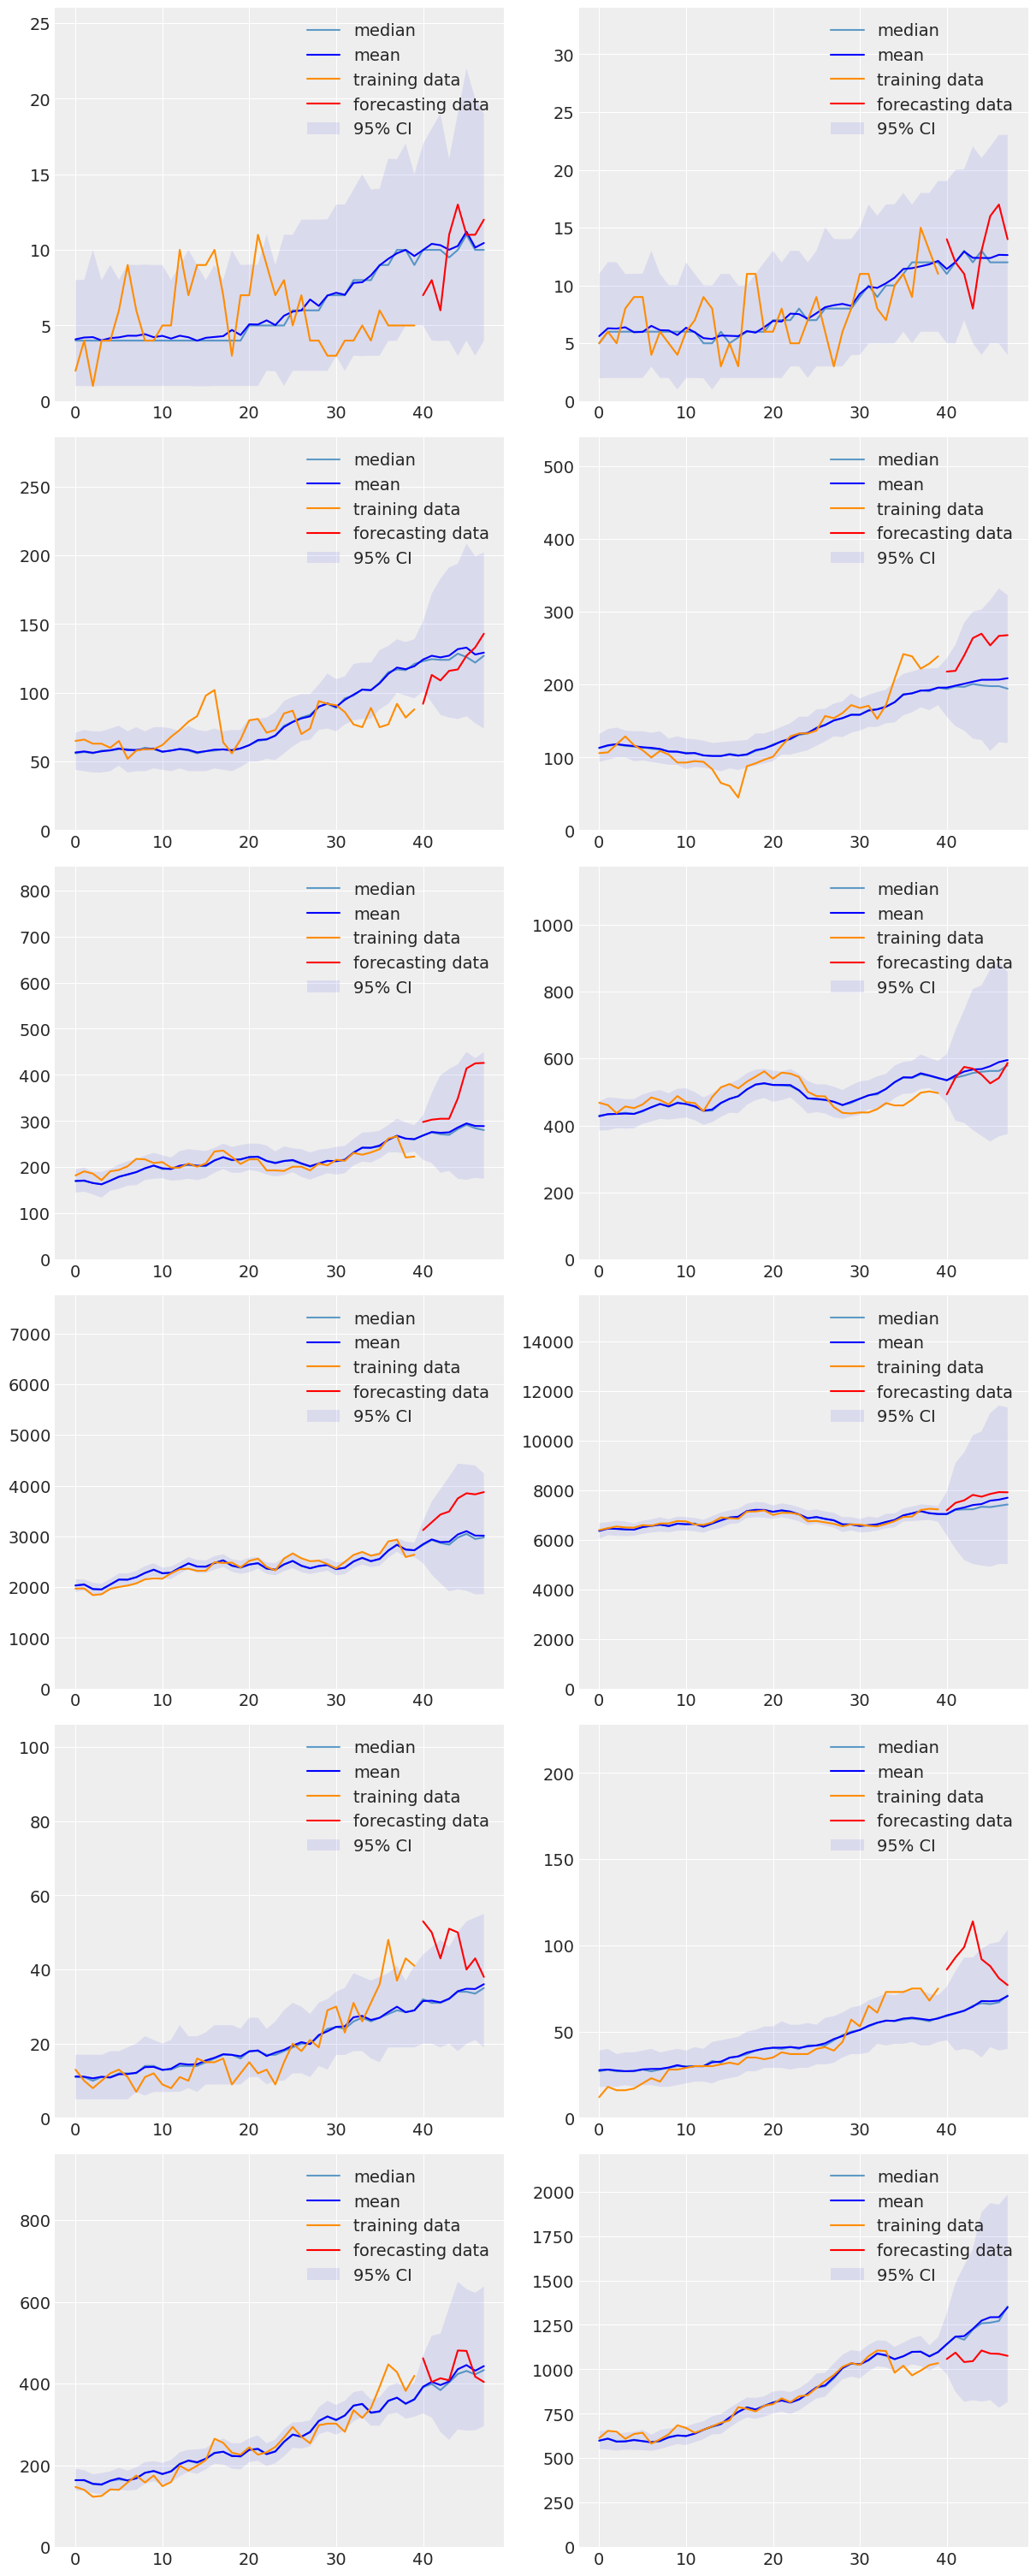

In [123]:
fig, ax = plt.subplots(6, 2, figsize=(12,30))
ax = np.ravel(ax)

for i in range(12):
    #ax[i].plot(np.arange(n_new), pred_samples['y_pred_new'].T[i*n:i*n+n,:], alpha=0.003, color='blue')
    ax[i].fill_between(np.arange(n_new), 
                       np.percentile(pred_samples['y_pred_new'].T[i*n:i*n+n,:], axis=1, q=2.5),
                      np.percentile(pred_samples['y_pred_new'].T[i*n:i*n+n,:], axis=1, q=97.5),
                      label='95% CI', alpha=0.1)
    ax[i].plot(np.arange(n_new), np.median(pred_samples['y_pred_new'].T[i*n:i*n+n,:], axis=1), color='tab:blue', alpha=0.7, label='median')
    ax[i].plot(np.arange(n_new), np.mean(pred_samples['y_pred_new'].T[i*n:i*n+n,:], axis=1), color='b', label='mean')
    ax[i].set_ylim(0,max(y_f[:,i])*2)
    ax[i].plot(y_f[:-8,i], color='darkorange', label='training data')
    ax[i].plot(np.arange(n_new -8, n_new), y_f[n_new-8:,i], color='r', label='forecasting data')
    ax[i].legend();

In [124]:
(mase_bottom_mean_m2, 
 mase_total_mean_m2, 
 mase_state_mean_m2, 
 mase_gender_mean_m2,
 mase_legal_mean_m2,
 mase_all_mean_m2) = calculate_metrics(np.mean,
                      pred_samples, 
                      y_f, 
                      state_names,
                      gender_names,
                      legal_names)

# Results

In [125]:
metrics_list = ['MASE', 'Bottom', 'Total', 'State', 'Gender', 'Legal', 'All']
results_m1 = ["m1",mase_bottom_mean_m1, 
                 mase_total_mean_m1, 
                 mase_state_mean_m1, 
                 mase_gender_mean_m1,
                 mase_legal_mean_m1,
                 mase_all_mean_m1]
results_m2 = ["m2",mase_bottom_mean_m2, 
                 mase_total_mean_m2, 
                 mase_state_mean_m2, 
                 mase_gender_mean_m2,
                 mase_legal_mean_m2,
                 mase_all_mean_m2]

In [126]:
table = [metrics_list,
         results_m1,
         results_m2]
display(HTML(tabulate.tabulate(table, tablefmt='html')))

MASE,Bottom,Total,State,Gender,Legal,All
m1,2.365,0.355,2.152,0.405,2.387,2.238
m2,2.219,0.469,1.547,0.628,2.886,2.055
